<a href="https://colab.research.google.com/github/EmaMule/Computer-Vision/blob/main/data/GroundDepthMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!git clone https://github.com/LiheYoung/Depth-Anything
!pip install -r /content/Depth-Anything/requirements.txt
!pip install spaces

Cloning into 'Depth-Anything'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 421 (delta 101), reused 43 (delta 39), pack-reused 277
Receiving objects: 100% (421/421), 237.89 MiB | 43.52 MiB/s, done.
Resolving deltas: 100% (144/144), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
cd Depth-Anything

/content/Depth-Anything


In [ ]:
import gradio as gr
import cv2
import numpy as np
import os
from PIL import Image
import spaces
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
import tempfile
from gradio_imageslider import ImageSlider

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

In [ ]:
@spaces.GPU
@torch.no_grad()
def predict_depth(model, image):
    return model(image)


def obtain_depth_map(model, transform, img_path):

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  image = Image.open(img_path)
  image = np.array(image)

  original_image = image.copy()

  h, w = image.shape[:2]

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
  image = transform({'image': image})['image']
  image = torch.from_numpy(image).unsqueeze(0).to(device)

  depth = predict_depth(model, image)
  depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]

  raw_depth = Image.fromarray(depth.cpu().numpy().astype('uint16'))
  tmp = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
  raw_depth.save(tmp.name)

  depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
  depth = depth.cpu().numpy().astype(np.uint8)
  colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

  return colored_depth

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = 'vitl'
model = DepthAnything.from_pretrained(f"LiheYoung/depth_anything_{encoder}14").to(device).eval()

transform = Compose([
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
])

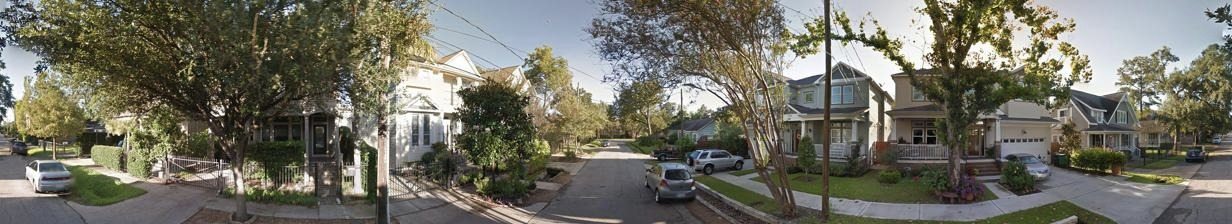

In [ ]:
image = Image.open('/content/image.jpg')
image

In [ ]:
colored_depth = obtain_depth_map(model, transform, "/content/image.jpg")

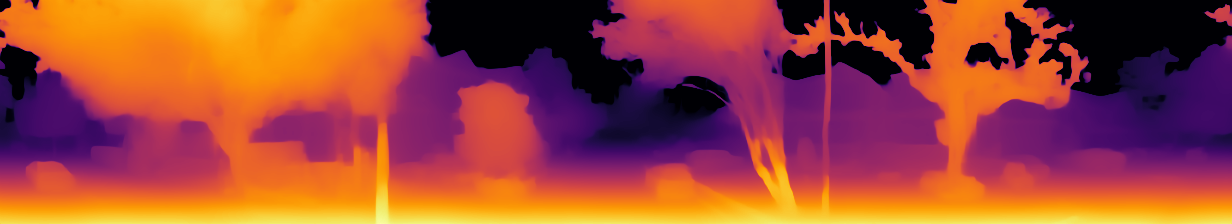

In [ ]:
depth_image = Image.fromarray(colored_depth)
depth_image